In [1]:
import numpy as np, matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
# Read in the mc
neutrinos = np.genfromtxt("./neutrino_mc.csv", delimiter=',', names=True)
muons = np.genfromtxt("./muon_mc.csv", delimiter=',', names=True)

In [3]:
# Read in the hyperplane parameters
hp_nue_cc = np.genfromtxt("./hyperplanes_nue_cc.csv", delimiter=',', names=True)
hp_numu_cc = np.genfromtxt("./hyperplanes_numu_cc.csv", delimiter=',', names=True)
hp_nutau_cc = np.genfromtxt("./hyperplanes_nutau_cc.csv", delimiter=',', names=True)
hp_nu_nc = np.genfromtxt("./hyperplanes_all_nc.csv", delimiter=',', names=True)
hp_muons = np.genfromtxt("hyperplanes_muon.csv", delimiter=',', names=True)

In [4]:
# The bestfit values for Analysis A NC+CC from Table 2
best_fit = {'ice_absorption': 101.5,
            'ice_scattering': 103.0,
            'opt_eff_headon': -0.63,
            'opt_eff_lateral': 0.49,
            'opt_eff_overall': 98.4,
            'coin_fraction': 0.01}

In [10]:
# Write the function definition for neutrinos
# This will take the values for each parameter and return
# the modified weight for each event
def apply_neutrinos(neutrinos=neutrinos,
                    hyperplanes = {0: hp_nu_nc,
                                   12: hp_nue_cc,
                                   14: hp_numu_cc,
                                   16: hp_nutau_cc,},
                    ice_absorption = 100.0,
                    ice_scattering = 100.0,
                    opt_eff_headon = 0.0,
                    opt_eff_lateral = 0.0,
                    opt_eff_overall = 100.0,
                    coin_fraction = 0.0,
                    **kwargs):
    
    # Copy the weights so we can modify them and 
    # assign an "interaction type" corresponding to
    # nue CC, numu CC, nutau CC or NC
    output_weights = np.copy(neutrinos['weight'])
    int_type = np.copy(neutrinos['pdg']).astype(int)
    int_type[neutrinos['type']==0] = 0 
    int_type = np.abs(int_type)

    # Apply each neutrino flavor separately using the PDG
    # codes for each. Note that we're using 0 for NC interactions
    # and 12/14/16 for nue/numu/nutau CC interactions respectively
    for flavor, hp in hyperplanes.items():
        bins_cz = hyperplanes[flavor]['reco_coszen']
        bins_en = hyperplanes[flavor]['reco_energy']
        bins_pid = hyperplanes[flavor]['pid']
        bins = np.array([bins_cz, bins_en, bins_pid]).T
        
        modifications = hp['offset'] + \
                        hp['ice_scattering'] * (ice_scattering-100)/100. +\
                        hp['ice_absorption'] * (ice_absorption-100)/100. +\
                        hp['opt_eff_lateral'] * (10*opt_eff_lateral) +\
                        hp['opt_eff_headon'] * (opt_eff_headon) +\
                        hp['opt_eff_overall'] * (opt_eff_overall-100)/100. +\
                        hp['coin_fraction'] * (coin_fraction)
        
        # Apply the modifications for a single neutrino flavor
        for i, b in enumerate(bins):
            mask = (int_type==flavor)
            mask &= (neutrinos['reco_coszen'] == b[0])
            mask &= (neutrinos['reco_energy'] == b[1])
            mask &= (neutrinos['pid'] == b[2])
            output_weights[mask] *= modifications[i]
        
    return output_weights
        

In [11]:
# Write the function definition for muons
# This will take the values for each parameter and return
# the modified weight for each event
def apply_muons(muons=muons,
                hyperplane = hp_muons,
                ice_absorption = 100.0,
                ice_scattering = 100.0,
                opt_eff_headon = 0.0,
                opt_eff_lateral = 0.0,
                opt_eff_overall = 100.0,
                **kwargs):
    
    # Copy the weights so we can modify them
    output_weights = np.copy(muons['weight'])

    # Get the bins for the muons
    bins_cz = hyperplane['reco_coszen']
    bins_en = hyperplane['reco_energy']
    bins_pid = hyperplane['pid']
    bins = np.array([bins_cz, bins_en, bins_pid]).T
        
    modifications = hyperplane['offset'] +\
        hyperplane['ice_scattering']*(ice_scattering-100)/100. +\
        hyperplane['opt_eff_lateral']*(10*opt_eff_lateral) +\
        hyperplane['opt_eff_headon']*(opt_eff_headon) +\
        hyperplane['ice_absorption']*(np.exp(hyperplane['ice_absorption_expslope']*(ice_absorption/100.-1.0))-1) +\
        hyperplane['opt_eff_overall']*(np.exp(hyperplane['opt_eff_overall_expslope']*(opt_eff_overall/100.-1.0))-1)

    # Apply the modifications to the muon weights
    for i, b in enumerate(bins):
        mask = (muons['reco_coszen'] == b[0])
        mask &= (muons['reco_energy'] == b[1])
        mask &= (muons['pid'] == b[2])
        output_weights[mask] *= modifications[i]
        
    return output_weights
        

ValueError: `bins[1]` must be monotonically increasing, when an array

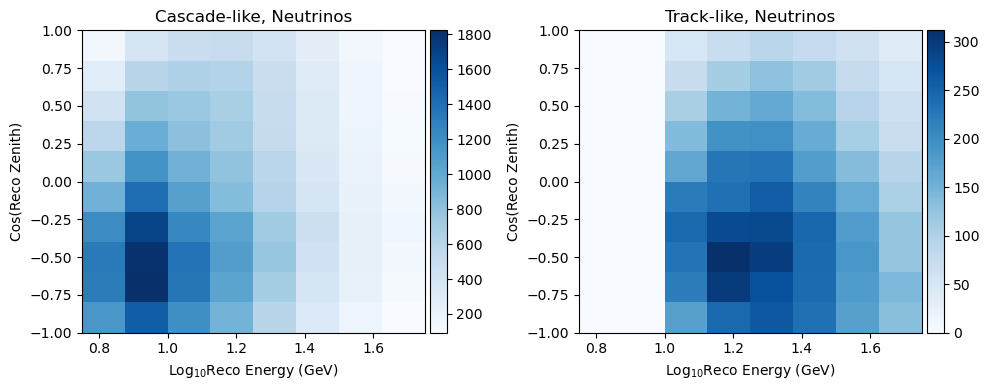

In [12]:
# Make a plot of the neutrinos just to verify the shape is correct
bins_en = np.log10([5.623413,  7.498942, 10. , 
                    13.335215, 17.782795, 23.713737, 
                    31.622776, 42.16965 , 56.23413])
bins_cz = np.array([-1., -0.8, -0.6 , -0.4, -0.2, 
                    0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
bins_pid = np.array([0, 1, 2])

# Choose the nuisance parameters for the detector systematics
#neutrino_weights = neutrino_muons()
neutrino_weights = apply_neutrinos(**best_fit)

# A flux model must be assumed for the neutrinos
# Here, use a simple flux of phi=800*E^-3.7 
# Note that this is only for the purposes of an
# example: fits performed using this sample should
# use a numerical flux calculation such as the one
# presented in PhysRevD.92.023004
# In principle, this is also where you would apply
# the neutrino oscillation probabilities
neutrino_weights *= 800*neutrinos['true_energy']**-3.7

# Scale to the livetime of the data
neutrino_weights *= 1006*24*3600. 

# Make the histogram, binning in energy, zenith, and pid
nu_hist, edges = np.histogramdd([np.log10(neutrinos['reco_energy']),
                                 neutrinos['reco_coszen'],
                                 neutrinos['pid']],
                                bins = [bins_en, bins_cz, bins_pid],
                                weights = neutrino_weights)

# Make a figure
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4))
cmesh = ax1.pcolormesh(bins_en, 
                       bins_cz,
                       nu_hist[:,:,0].T,
                       cmap='Blues')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cmesh, cax)

cmesh = ax2.pcolormesh(bins_en, 
                       bins_cz,
                       nu_hist[:,:,1].T,
                       cmap='Blues')
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cmesh, cax)

ax1.set_title('Cascade-like, Neutrinos')
ax1.set_ylabel("Cos(Reco Zenith)")
ax1.set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
ax2.set_ylabel("Cos(Reco Zenith)")
ax2.set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
ax2.set_title('Track-like, Neutrinos')

fig.tight_layout()

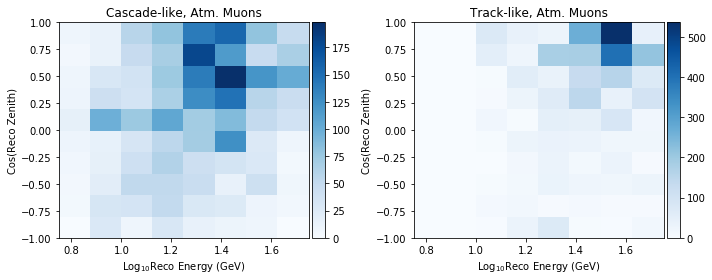

In [8]:
# Make a plot of the muons just to verify the shape is correct
bins_en = np.log10([5.623413,  7.498942, 10. , 
                    13.335215, 17.782795, 23.713737, 
                    31.622776, 42.16965 , 56.23413])
bins_cz = np.array([-1., -0.8, -0.6 , -0.4, -0.2, 
                    0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
bins_pid = np.array([0, 1, 2])

# Choose the nuisance parameters for the detector systematics
#muon_weights = np.copy(muons['weight'])
#muon_weights = apply_muons()
muon_weights = apply_muons(**best_fit)

# Weights are in Hz. Convert to about the 
# livetime given in Section IV
muon_weights *= 1006*24*3600. 

# Make the histogram, binning in energy, zenith, and pid
muon_hist, edges = np.histogramdd([np.log10(muons['reco_energy']),
                                   muons['reco_coszen'],
                                   muons['pid']],
                                  bins = [bins_en, bins_cz, bins_pid],
                                  weights = muon_weights)

# Make a figure
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4))
cmesh = ax1.pcolormesh(bins_en, 
                       bins_cz,
                       muon_hist[:,:,0].T,
                       cmap='Blues')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cmesh, cax)

cmesh = ax2.pcolormesh(bins_en, 
                       bins_cz,
                       muon_hist[:,:,1].T,
                       cmap='Blues')
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cmesh, cax)

ax1.set_title('Cascade-like, Atm. Muons')
ax1.set_ylabel("Cos(Reco Zenith)")
ax1.set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
ax2.set_ylabel("Cos(Reco Zenith)")
ax2.set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
ax2.set_title('Track-like, Atm. Muons')

fig.tight_layout()